## Import Libraries

In [164]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import skfuzzy as fuzz
from skfuzzy import control as ctrl

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


## Load the Data

In [31]:
df = pd.read_csv(r'D:\ML\GreenHouse_ai_fuzzy\Data\GreenHouseData.csv', sep=';', engine='python', encoding='utf-8', on_bad_lines='skip')
df.head()

,id,greenhous_temperature_celsius,greenhouse_humidity_percentage,greenhouse_illuminance_lux,online_temperature_celsius,online_humidity_percentage,greenhouse_total_volatile_organic_compounds_ppb,greenhouse_equivalent_co2_ppm,created
0,361496,"13,22325653500027","68,05557590060764",0,"7,300000190734863",89.0,370,"1080,4444444444443",2021-03-03 20:10:04
1,361543,"13,149614620208741","68,27115402221679",0,"6,300000190734863",91.0,"380,3","1068,1",2021-03-03 20:20:03
2,361595,"13,094339275360108","68,40222930908203",0,"6,300000190734863",91.0,371,"1022,7",2021-03-03 20:30:04
3,361647,"12,989395236968994","68,48355865478516",0,"5,300000190734863",94.0,363,"995,6",2021-03-03 20:40:03
4,361699,"12,901927100287544","68,55691952175565",0,"5,400000095367432",94.0,350,"960,8888888888889",2021-03-03 20:50:05


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 9 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   id                                               17562 non-null  int64  
 1   greenhous_temperature_celsius                    17164 non-null  object 
 2   greenhouse_humidity_percentage                   17164 non-null  object 
 3   greenhouse_illuminance_lux                       17164 non-null  object 
 4   online_temperature_celsius                       17556 non-null  object 
 5   online_humidity_percentage                       17556 non-null  float64
 6   greenhouse_total_volatile_organic_compounds_ppb  17164 non-null  object 
 7   greenhouse_equivalent_co2_ppm                    17164 non-null  object 
 8   created                                          17562 non-null  object 
dtypes: float64(1), int64(1), obje

## Clean the Data

In [33]:
# Null values 
df.isnull().sum()

id                                                   0
greenhous_temperature_celsius                      398
greenhouse_humidity_percentage                     398
greenhouse_illuminance_lux                         398
online_temperature_celsius                           6
online_humidity_percentage                           6
greenhouse_total_volatile_organic_compounds_ppb    398
greenhouse_equivalent_co2_ppm                      398
created                                              0
dtype: int64

- Since the we have a noticable number of instances we can delete the null values

In [34]:
# Drop the rows with null values
df.dropna(inplace=True)

In [35]:
# check for duplicated rows
print(f'Number of duplicated values: {df.duplicated().sum()}')

Number of duplicated values: 0


- We have no duplicated values

In [36]:
df['created']=pd.to_datetime(df['created'])
df.set_index('created',inplace=True)

df.head(3)

,id,greenhous_temperature_celsius,greenhouse_humidity_percentage,greenhouse_illuminance_lux,online_temperature_celsius,online_humidity_percentage,greenhouse_total_volatile_organic_compounds_ppb,greenhouse_equivalent_co2_ppm
created,,,,,,,,
2021-03-03 20:10:04,361496,"13,22325653500027","68,05557590060764",0,"7,300000190734863",89.0,370,"1080,4444444444443"
2021-03-03 20:20:03,361543,"13,149614620208741","68,27115402221679",0,"6,300000190734863",91.0,"380,3","1068,1"
2021-03-03 20:30:04,361595,"13,094339275360108","68,40222930908203",0,"6,300000190734863",91.0,371,"1022,7"


- As we can see decimal points in the data is represented with ',' witch is not good so we need to replace it with '.'

In [37]:
df = df.map(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)
df = df.astype(float, errors='ignore')
df.head(3)

,id,greenhous_temperature_celsius,greenhouse_humidity_percentage,greenhouse_illuminance_lux,online_temperature_celsius,online_humidity_percentage,greenhouse_total_volatile_organic_compounds_ppb,greenhouse_equivalent_co2_ppm
created,,,,,,,,
2021-03-03 20:10:04,361496.0,13.223257,68.055576,0.0,7.3,89.0,370.0,1080.444444
2021-03-03 20:20:03,361543.0,13.149615,68.271154,0.0,6.3,91.0,380.3,1068.100000
2021-03-03 20:30:04,361595.0,13.094339,68.402229,0.0,6.3,91.0,371.0,1022.700000


In [41]:
# We don't need the id column for our analysis
df.drop(columns=['id'],inplace=True)

## Numerical Analysis

In [42]:
df.nunique()

greenhous_temperature_celsius                      16870
greenhouse_humidity_percentage                     16992
greenhouse_illuminance_lux                         10156
online_temperature_celsius                           365
online_humidity_percentage                            82
greenhouse_total_volatile_organic_compounds_ppb    12261
greenhouse_equivalent_co2_ppm                      10808
dtype: int64

In [43]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
greenhous_temperature_celsius,17158.0,25.873563,13.039837,4.972237,14.945047,24.114576,31.744182,77.566312
greenhouse_humidity_percentage,17158.0,52.911973,13.080862,15.313954,45.491633,55.615701,63.776569,82.900305
greenhouse_illuminance_lux,17158.0,3721.429191,5737.604175,0.000000,0.000000,900.716667,5239.050000,36489.333333
online_temperature_celsius,17158.0,11.193531,6.682947,-4.900000,6.000000,10.500000,15.500000,32.299999
online_humidity_percentage,17158.0,73.635738,17.892312,18.000000,60.000000,76.000000,89.000000,100.000000
greenhouse_total_volatile_organic_compounds_ppb,17158.0,979.670974,1058.915639,0.000000,463.500000,631.236111,1161.875000,13114.100000
greenhouse_equivalent_co2_ppm,17158.0,1219.272447,1234.814144,400.000000,424.125000,986.050000,1385.975000,18113.400000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


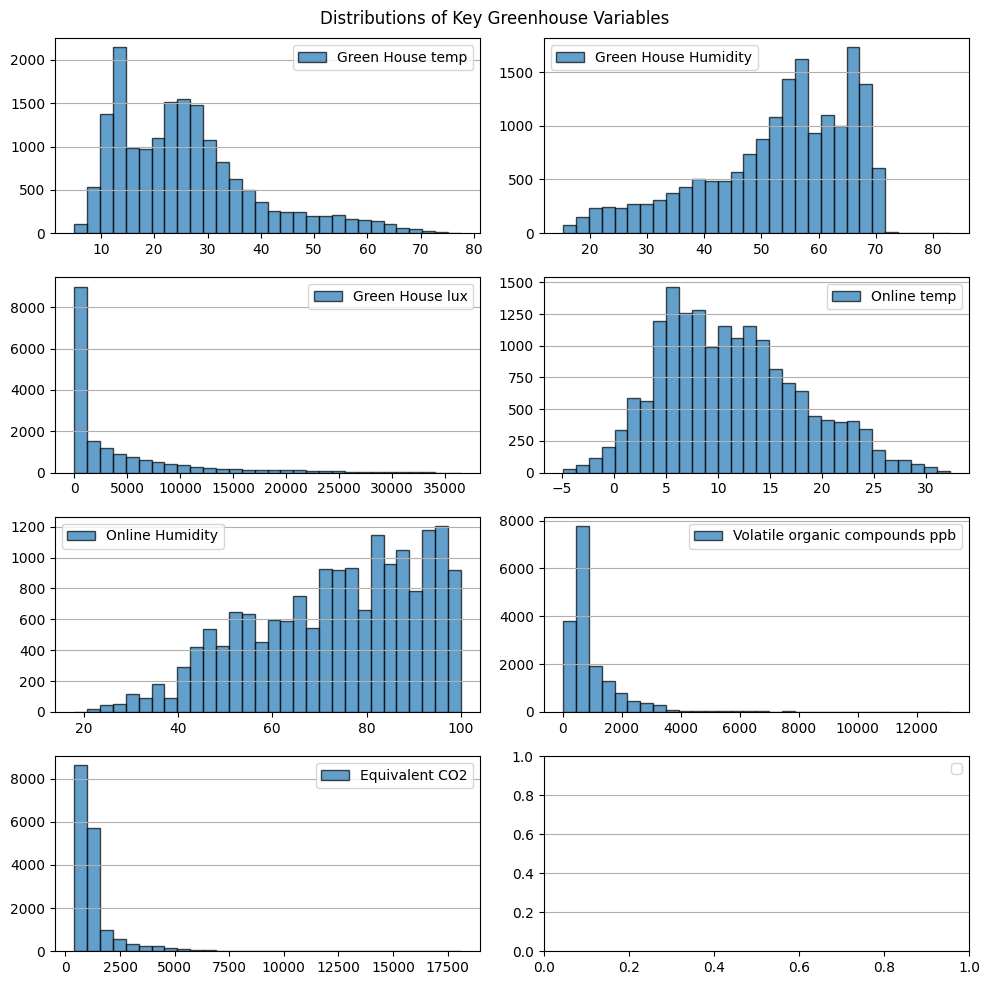

In [78]:
fig,ax=plt.subplots(4,2,figsize=(10,10))
fig.suptitle('Distributions of Key Greenhouse Variables')

ax[0,0].hist(df['greenhous_temperature_celsius'],bins=30,edgecolor='black',label='Green House temp',alpha=0.7)
ax[0,1].hist(df['greenhouse_humidity_percentage'],bins=30,edgecolor='black',label='Green House Humidity',alpha=0.7)
ax[1,0].hist(df['greenhouse_illuminance_lux'],bins=30,edgecolor='black',label='Green House lux',alpha=0.7)
ax[1,1].hist(df['online_temperature_celsius'],bins=30,edgecolor='black',label='Online temp',alpha=0.7)
ax[2,0].hist(df['online_humidity_percentage'],bins=30,edgecolor='black',label='Online Humidity',alpha=0.7)
ax[2,1].hist(df['greenhouse_total_volatile_organic_compounds_ppb'],bins=30,edgecolor='black',label='Volatile organic compounds ppb',alpha=0.7)
ax[3,0].hist(df['greenhouse_equivalent_co2_ppm'],bins=30,edgecolor='black',label='Equivalent CO2',alpha=0.7)

for i in range(4):
    for j in range(2):
        ax[i,j].legend()
        ax[i,j].grid(axis='y')

plt.tight_layout()
plt.show()


### 📊 Distribution Analysis of Greenhouse Environmental Variables




### 🌡️ Greenhouse Temperature (°C)
- **Distribution:** Right-skewed, with most values clustering between 12°C and 22°C, and a long tail extending toward higher temperatures.
- **Insight:** The skew suggests that lower temperatures are more common in the greenhouse environment, likely reflecting cooler nighttime periods or a controlled growing climate. The less frequent high-temperature readings may correspond to peak sunlight hours or brief climate fluctuations. This pattern is important for time-series forecasting, as it hints at daily cyclic behavior and outlier sensitivity.

---

### 💧 Greenhouse Humidity (%)
- **Distribution:** Skewed toward higher humidity values, with most readings between 60% and 80%.
- **Insight:** The greenhouse tends to operate in a high-humidity environment, which is favorable for plant growth but could require control adjustments depending on the crop type.

---

### 💡 Greenhouse Illuminance (Lux)
- **Distribution:** Highly right-skewed; the majority of readings are under 5000 lux, with a long tail extending to 30,000+ lux.
- **Insight:** Suggests natural lighting dominates with occasional intense light bursts—possibly due to direct sunlight. May benefit from light smoothing or shading automation.

---

### 🌍 Online Temperature (°C)
- **Distribution:** Symmetrical and normal, centered around 5°C–20°C.
- **Insight:** Reflects external climate patterns outside the greenhouse—useful as input for predictive modeling.

---

### 🌫️ Online Humidity (%)
- **Distribution:** Left-skewed and dense in the 60%–90% range.
- **Insight:** Correlates well with internal humidity, indicating that external moisture may influence internal greenhouse behavior.

---

### 🧪 Total Volatile Organic Compounds (ppb)
- **Distribution:** Right-skewed with most values between 0 and 1000 ppb.
- **Insight:** A sharp peak at the low end suggests generally clean air, with occasional pollution spikes—possibly during equipment usage or ventilation changes.

---

### 🫁 Equivalent CO₂ (ppm)
- **Distribution:** Similar to VOCs—heavily right-skewed with most values under 3000 ppm.
- **Insight:** Low levels dominate, which is positive for both worker safety and plant respiration. Outlier spikes should be examined for equipment-related emissions.

---

### 🔎 Summary
- Most variables display **non-normal**, skewed distributions.
- The system appears to favor **humid and temperature-stable conditions**.
- Skewed data suggests preprocessing (e.g., normalization or log transform) may be useful before modeling.
- Variance in light and CO₂ implies possible targets for intelligent fuzzy control actions.

## Time Series Analysis

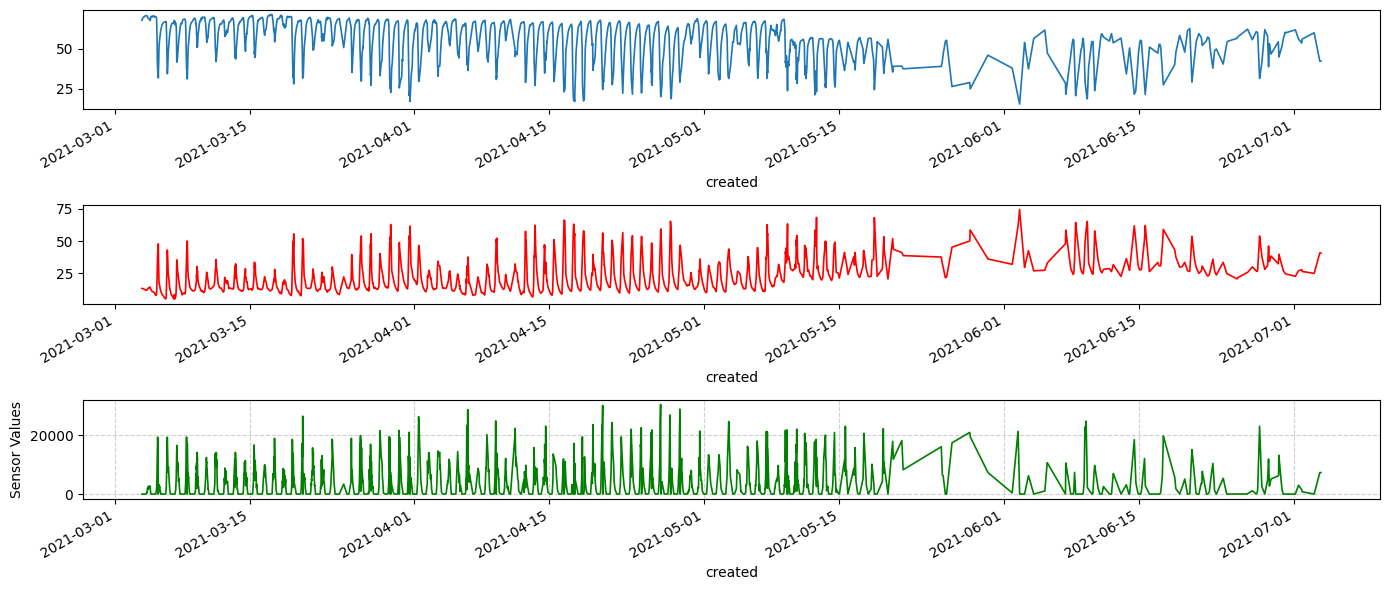

In [93]:
fig,ax = plt.subplots(3,1)
df[ 'greenhouse_humidity_percentage'].plot(
    figsize=(14, 6),
    linewidth=1.2,
    ax=ax[0]
)

df['greenhous_temperature_celsius'].plot(
    figsize=(14, 6),
    linewidth=1.2,
    ax=ax[1],
    color='red'
)

df['greenhouse_illuminance_lux'].plot(
    figsize=(14, 6),
    linewidth=1.2,
    ax=ax[2],
    color='green'
)
plt.ylabel("Sensor Values")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



### 📈 Time Series Analysis: Greenhouse Sensor Trends

This section analyzes the temporal behavior of three key greenhouse variables over the period from **March 1 to July 1, 2021**:

---

### 🌡️ Greenhouse Temperature (°C)
- **Pattern:** Oscillating with noticeable periodic fluctuations.
- **Range:** Approximately **25°C to 50°C**.
- **Insight:** The data suggests strong diurnal (daily) cycles likely caused by day–night temperature variation. Peaks align with daytime heating, while troughs represent nighttime cooling.
- **Forecast Implication:** Good candidate for time series models like LSTM that capture seasonality and short-term memory.

---

### 💧 Greenhouse Humidity (%)
- **Pattern:** Similarly fluctuating but not tightly coupled with temperature.
- **Range:** Varies between **0% and ~75%**.
- **Insight:** Humidity shows irregular changes, possibly due to irrigation events or ventilation cycles. There appears to be some inverse correlation with temperature (e.g., higher humidity during cooler periods).
- **Forecast Implication:** May benefit from multivariate forecasting, using temperature and time-of-day as context.

---

### 💡 Greenhouse Illuminance (Lux)
- **Pattern:** Highly spiky and periodic.
- **Range:** From **0 up to ~20,000 lux**.
- **Insight:** Clear day–night cycles, with illuminance dropping to zero during nights and peaking during daylight. Sharp spikes imply direct sun exposure through the greenhouse roof, reinforcing the idea of strong natural light dependency.
- **Forecast Implication:** Highly seasonal and predictable on a daily basis. Could be used as an exogenous variable to improve accuracy of temperature or humidity models.

---

### 🔎 Summary
These visual patterns confirm that:
- All three variables exhibit **strong time dependencies**.
- Temperature and illuminance have distinct **daily periodicity**.
- Humidity behaves more erratically, possibly influenced by control interventions (e.g., misting, fans).

### 🔄 Shift in Seasonal Pattern Around Mid-May 2021

Upon visual inspection of the greenhouse environmental time series, a notable structural change occurs around **2021-05-15**:

---

### 💧 Greenhouse Humidity (%)

- **Before 2021-05-15:**  
  Exhibits moderately cyclical behavior with relatively stable fluctuations between 50% and 75%. The patterns loosely mirror temperature trends, suggesting a degree of environmental coupling (e.g. cooler nights = higher relative humidity).

- **After 2021-05-15:**  
  A noticeable shift occurs—humidity becomes **significantly more erratic** with steeper fluctuations and lower troughs, occasionally dipping close to 0%. The seasonality visible before mid-May becomes disrupted or masked. This change may indicate:
  - Increased ventilation or dehumidification interventions
  - Sensor recalibration or malfunction
  - A change in external climate conditions such as drier air masses or heatwaves

- **Implication:**  
  This regime change reduces temporal consistency and makes prediction more difficult. For modeling:
  - Humidity should be forecasted using **shorter time windows**
  - Consider splitting data into pre/post-May segments to train models separately or introduce time-aware features

---

### 🌡️ Temperature and 💧 Humidity
- **Before 2021-05-15:**  
  Clear, rhythmic oscillations—consistent daily cycles in temperature and moderately synchronized humidity variations.
  
- **After 2021-05-15:**  
  Cycles become irregular; temperature fluctuations widen, and humidity shows increased volatility. This may indicate:
  - A change in external weather conditions (e.g. transition from spring to early summer)
  - Altered greenhouse control strategies or system maintenance
  - Equipment or data logging inconsistencies

---

### 💡 Illuminance (Lux)
- **Before:**  
  Illuminance shows typical day–night oscillations with sharp solar peaks.
- **After:**  
  A sudden change in spike intensity or periodic gaps may suggest:
  - Cloudier weather conditions or prolonged overcast periods
  - Installation of a shading system or structural greenhouse modification
  - Sensor calibration or logging issues



In [80]:
# Reindex to uniform 10-minute intervals
df = df.asfreq('10min')

# Fill missing values (interpolation or forward fill)
df.interpolate(method='linear', inplace=True)


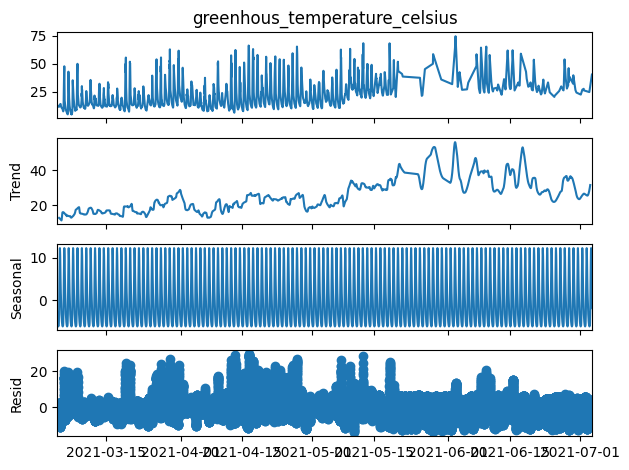

In [95]:
# Let's do the Decomposision

result= seasonal_decompose(df['greenhous_temperature_celsius'],model='additive',period=144) # 144 = 24 hrs * 6 readings/hour
result.plot()
plt.tight_layout()
plt.show()

### 📉 Seasonal Decomposition of Greenhouse Temperature


### 🔷 1. Trend Component
- **Interpretation:** Shows the long-term progression of temperature over time.
- **Observation:** There's a general upward trend until mid-May, followed by a plateau and moderate fluctuations.
- **Insight:** The gradual rise could reflect a seasonal warming pattern from spring into early summer.

---

### 🔁 2. Seasonal Component
- **Interpretation:** Captures the recurring daily cycles in temperature.
- **Observation:** Strong, regular oscillations consistent with diurnal heating and cooling patterns.
- **Insight:** This confirms that temperature in the greenhouse follows a predictable 24-hour rhythm—crucial for reliable LSTM training.

---

### ⚖️ 3. Residual Component
- **Interpretation:** What's left after removing the trend and seasonality—essentially noise or unpredictable variation.
- **Observation:** Residuals are mostly centered near zero, but show bursts of irregularity after mid-May.
- **Insight:** Increased volatility in residuals may correspond to environmental changes or shifts in greenhouse operation (e.g. altered ventilation schedules).

---

### 🧠 Takeaway
This decomposition validates the presence of **strong seasonality and a stable trend** during the early months, which are ideal conditions for time series modeling. However, the post-May behavioral shift warrants attention and may require either retraining or adaptive learning strategies in your forecasting model.


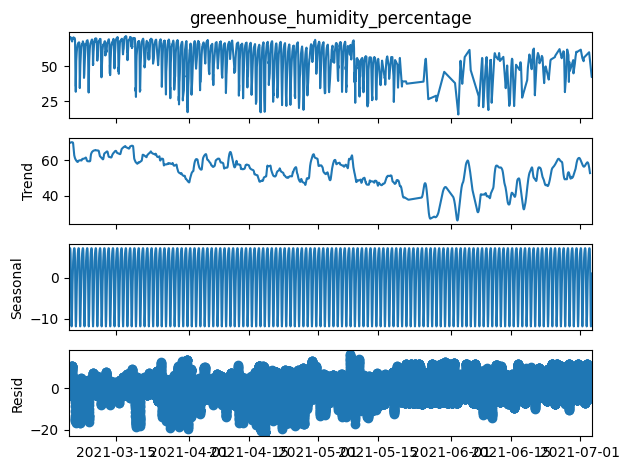

In [100]:

result= seasonal_decompose(df['greenhouse_humidity_percentage'],model='additive',period=144) # 144 = 24 hrs * 6 readings/hour
result.plot()
plt.tight_layout()
plt.show()

### 💧 Seasonal Decomposition – Greenhouse Humidity (%)


### 🔷 Observed (Original Data)
- **Range:** Approximately 25% to 50% humidity.
- **Pattern:** Initially displays cyclical daily behavior, but after mid-May, the pattern becomes more irregular and volatile.
- **Insight:** This supports the earlier observation that there’s a structural shift in humidity control or external climate conditions post-May 15.

---

### 📉 Trend Component
- **Direction:** Gradual decline from around 60% to below 40% over the course of 3.5 months.
- **Interpretation:** Suggests a long-term drying trend—either natural (e.g. hotter climate onset) or operational (e.g. stronger ventilation or reduced watering).

---

### 🔁 Seasonal Component
- **Pattern:** Repeating cycles with amplitude around ±10%.
- **Consistency:** Fairly regular in shape and frequency prior to May, indicating strong diurnal cycles driven by greenhouse operation or outdoor weather.
- **Disruption:** Post-May, the seasonal consistency weakens slightly—likely due to greater environmental volatility.

---

### ⚖️ Residuals (Noise)
- **Magnitude:** Fluctuates between -20% and +20%.
- **Observation:** More erratic after mid-May, aligning with your earlier insight about changing greenhouse dynamics.
- **Interpretation:** Indicates unpredictable spikes, likely from manual overrides, equipment events, or sudden external humidity changes.

---

### 🧠 Takeaway
- The humidity signal contains both **meaningful seasonality** and **non-trivial residual volatility**, especially in the latter half.
- This variable may require **hybrid modeling strategies**—such as LSTM combined with fuzzy rules—to account for both cyclical and sudden shifts in behavior.
- You might also consider using a **calendar-aware feature (e.g. day of year)** or splitting pre/post-May-15 into separate modeling regimes.

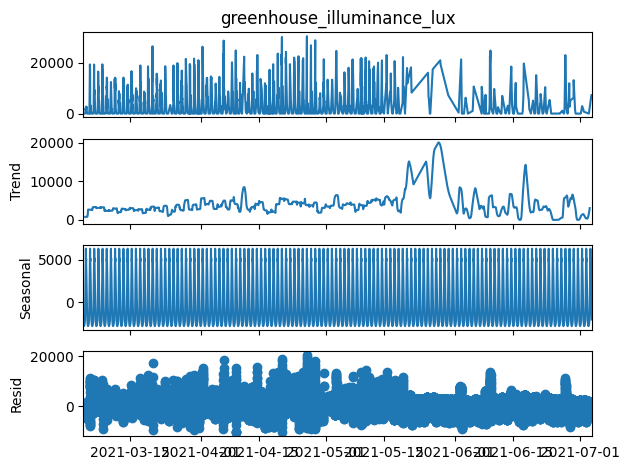

In [101]:
result= seasonal_decompose(df['greenhouse_illuminance_lux'],model='additive',period=144) # 144 = 24 hrs * 6 readings/hour
result.plot()
plt.tight_layout()
plt.show()

### 💡 Seasonal Decomposition – Greenhouse Illuminance (Lux)


### 🔷 Observed (Original Data)
- **Range:** Between 0 and 20,000+ lux.
- **Pattern:** Intense daily spikes that sharply rise and fall—this aligns with sunrise and sunset transitions.
- **Insight:** Indicates strong solar exposure with little artificial lighting influence. Zero illuminance periods perfectly match nighttime hours.

---

### 📉 Trend Component
- **Direction:** Generally upward from March through June.
- **Interpretation:** Suggests increasingly longer or brighter days—likely due to the seasonal transition from early spring to midsummer.
- **Notable:** The curve smooths out irregularities and offers a clear signal of how average light levels evolve month-to-month.

---

### 🔁 Seasonal Component
- **Pattern:** Repeating cycles with high amplitude and clear daily frequency.
- **Interpretation:** Validates strong **diurnal light cycles**—the system receives predictable light boosts during the day and total darkness at night.
- **Insight:** This is one of the most predictable and rhythmic features in the dataset—excellent for inclusion as a model input or for driving fuzzy logic rules around photosensitive behavior.

---

### ⚖️ Residuals (Noise)
- **Observation:** Mostly low and centered around zero.
- **Interpretation:** Minor unpredictable variation likely caused by intermittent cloud coverage, shading events, or sensor noise. Residuals show slightly more irregularity after May, possibly indicating a shift in external lighting patterns or atmospheric conditions.

---

### 🧠 Final Insight
- This variable demonstrates **highly structured daily seasonality**, minimal noise, and predictable trend behavior.
- A strong candidate as a **supporting feature** for modeling temperature or humidity.
- Also ideal for building fuzzy rules tied to daylight exposure (e.g. "If light is high and humidity is low, increase misting").

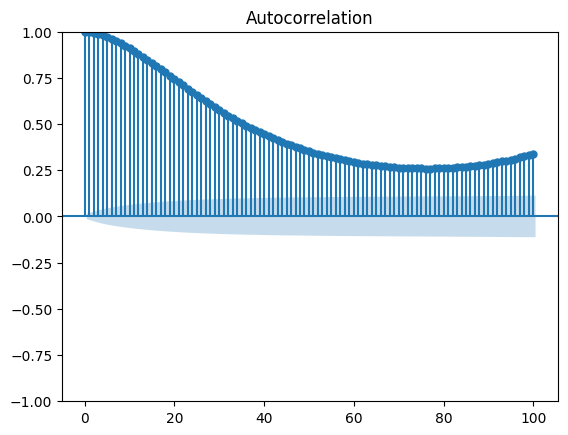

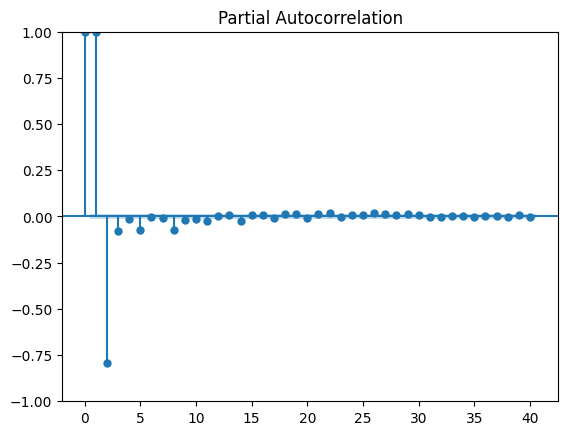

In [99]:
plot_acf(df['greenhous_temperature_celsius'].dropna(),lags=100)
plot_pacf(df['greenhous_temperature_celsius'].dropna(),lags=40)
plt.show()

### 📉 Autocorrelation (ACF) Analysis – Greenhouse Temperature


### 🧠 Key Observations

- **Strong autocorrelation at small lags (lag 1–20):**  
  Temperature shows very high correlation with recent past readings—excellent for short-term prediction.

- **Gradual decay across lags:**  
  Autocorrelation fades slowly instead of dropping sharply. This suggests a **long memory process**, meaning the system remembers not just the last hour but many hours into the past.

- **Notable seasonal spike around lag 144:**  
  If you see a bump or spike near lag 144, that maps to **24 hours**, confirming a clear **daily cycle** in greenhouse temperature.

- **Most values fall within the confidence bounds beyond lag ~60:**  
  Indicates that correlations beyond this point are mostly statistical noise—little predictive power.

---

### ✅ Modeling Implications

- A **lookback window of 6 to 12 hours** (i.e. 36–72 steps) would be ideal for LSTM input.
- LSTM is a better fit than simple AR models here, because:
  - The slow decay implies **non-linearity**
  - You likely have **multiple seasonalities** (daily light, temperature, control behavior)

---


### 🔍 Partial Autocorrelation (PACF) Analysis – Greenhouse Temperature

### 📉 Observations from Your PACF Plot

- **Lag 1:** Very high correlation (~0.9), strongly influences the present temperature.
- **Lag 2:** Also significant (~0.7–0.8), suggesting recent values continue to carry weight.
- **Lag 3:** **Significant negative spike (~-0.75)** — suggests an alternating pattern or overshooting behavior in short-term dynamics.
- **Lags 4 and beyond:** Most bars drop within the confidence interval → little to no added predictive power from older lags.

---

### 🧠 Interpretation

- The sharp cutoff after lag 3 indicates that the **first 2–3 past readings** carry most of the predictive signal.
- Beyond that, the direct influence weakens—meaning your model doesn't need to rely on a long past history for effective short-term forecasts.


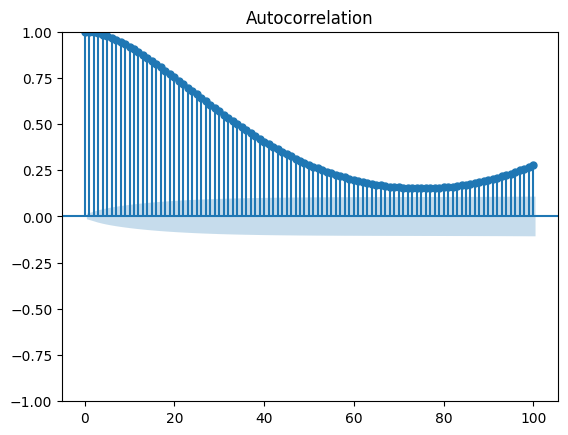

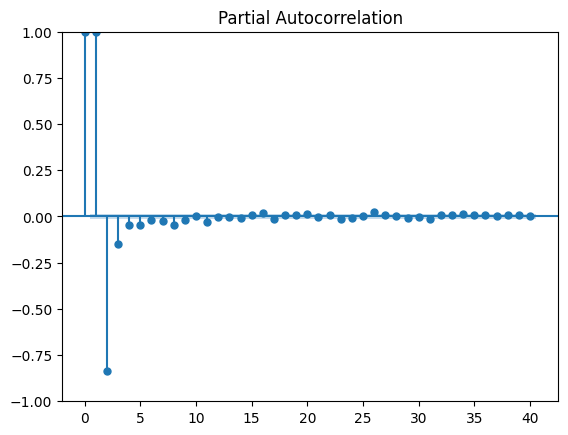

In [102]:
plot_acf(df['greenhouse_humidity_percentage'].dropna(),lags=100)
plot_pacf(df['greenhouse_humidity_percentage'].dropna(),lags=40)
plt.show()

### 🔁 Partial Autocorrelation (PACF) Analysis – Greenhouse Humidity (%)


### 🔎 Key Observations
- **Lag 1 and 2:** Very high partial autocorrelations (both close to **+1**) → strong short-term memory in humidity.
- **Lag 3:** Large **negative spike** (close to **−1**) → possible overshooting behavior or cyclic response in the short term.
- **Lags 4 and beyond:** Fall within the blue confidence bounds, suggesting these are not statistically significant (no strong direct correlation with current value).

---

### 🧠 Interpretation
- The plot displays a **sharp cutoff after lag 3**, meaning lags beyond that don’t add much direct predictive power.
- The negative lag-3 spike suggests a **delayed correction effect**—perhaps when humidity rises, it tends to fall after 30 minutes due to active climate control.

---

### ✅ Modeling Recommendation
- For LSTM or other sequence-based models:
  - Use a **minimum input sequence of 3–4 steps** (i.e. 30–40 minutes) to capture meaningful past influence.
  - If you're including other variables like illuminance or temperature, try **multivariate input** within this short-term window.

- For classic AR models:
  - An **AR(3)** model might be optimal here.

### 📉 Autocorrelation Function (ACF) – Greenhouse Humidity (%)

### 🔎 Observations from the ACF Plot

- **Lags 1–4:**  
  Strong positive autocorrelations → recent humidity readings influence the current value significantly.

- **Lag 5–15:**  
  Gradual decline, with correlations tapering but still above zero.

- **Beyond Lag 20:**  
  Most spikes fall within the confidence band, suggesting weak or negligible autocorrelation.

- **No obvious seasonal spikes at lag 144:**  
  Unlike temperature or illuminance, humidity lacks a strong daily periodic signature here.

---

### 🧠 Interpretation

- The **strong short-term memory** in early lags means:
  > “The humidity now is still closely related to the last 30–60 minutes.”

- **Long-term autocorrelation fades**:  
  Humidity becomes harder to predict based on older readings alone.

- Absence of long-range seasonality implies that **humidity may be more reactive**, possibly to ventilation, misting, or external weather conditions.

---

### ✅ Modeling Insight

- Use a short lookback window: **6–12 steps** (1–2 hours) for LSTM models.
- Humidity might benefit more from **exogenous variables** like temperature or illuminance as model inputs.
- Consider modeling pre- and post–May 15 separately due to trend behavior shifts noted earlier.

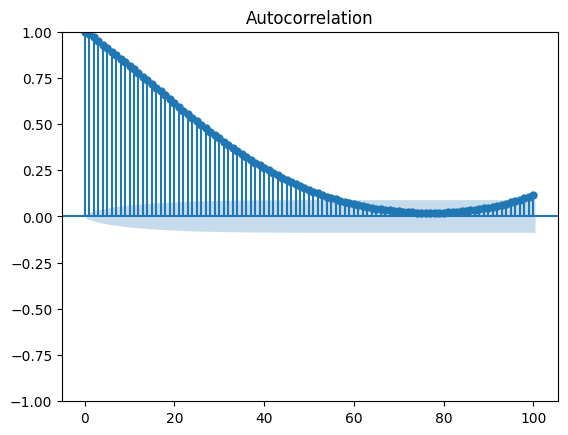

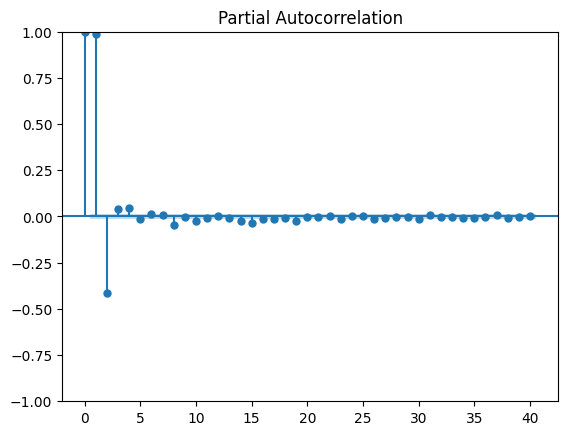

In [103]:
plot_acf(df['greenhouse_illuminance_lux'].dropna(),lags=100)
plot_pacf(df['greenhouse_illuminance_lux'].dropna(),lags=40)
plt.show()

### 📊 Autocorrelation Function (ACF) – Greenhouse Illuminance (Lux)

### 🔎 Key Observations
- **Lag 1 to 20:**  
  Strong positive autocorrelation, gradually declining. Indicates that current illuminance depends heavily on the very recent past—natural for sunlight, which changes gradually through the day.
  
- **Lag ~144 (1 day):**  
  A noticeable secondary peak appears here, confirming a **daily seasonality pattern**—exactly what we’d expect from natural daylight cycles.

- **Repeating smaller peaks near multiples of 144 (e.g. ~288):**  
  Suggests **multi-day periodicity**, likely from repeating sunrise/sunset cycles in stable weather windows.

- **No abrupt drop in autocorrelation:**  
  Gradual decay implies **strong temporal coherence**, making this an ideal input feature for forecasting or rule-based control.

---

### 🧠 Interpretation
- Illuminance is **highly predictable** on short and daily scales.
- The data strongly reflects a **solar rhythm**, which can be leveraged in:
  - LSTM or temporal models
  - Fuzzy logic for greenhouse lighting systems (e.g. activating blinds or artificial lights)
  - Enriching other forecasts (e.g. anticipating temperature rises based on light input)

---

### ✅ Recommendation
- Include **at least 144 lags (1 day)** in your lookback window if capturing seasonal light behavior.
- If modeling short-term light shifts, even a **1–2 hour window** provides meaningful predictive power.

---

### 🔁 Partial Autocorrelation Function (PACF) – Greenhouse Illuminance (Lux)

### 🔎 Key Observations
- **Lag 1:** Very strong positive correlation (~+1) → current illuminance is nearly identical to 10 minutes ago.
- **Lag 2:** Still significantly positive (~+0.75), reflecting the smooth nature of natural daylight transitions.
- **Lag 3:** Large **negative partial autocorrelation (~−0.5)** → suggests an oscillation or slight overreaction in short-term light fluctuations (e.g. quick cloud cover changes).
- **Lags 4 and beyond:** Mostly fall within the confidence bounds, indicating **no significant direct influence** from those lags.

---

### 🧠 Interpretation
- This is a classic **short-memory signal**: very recent readings matter, but older ones lose impact quickly.
- The sharp dropoff after lag 3 suggests that illuminance depends mainly on the **last 30 minutes** of readings.
- The negative lag-3 spike could reflect physical factors like shading, auto-blinds, or brief cloud interruptions correcting themselves.

---

### ✅ Modeling Implication
- Use an input window of **3–6 steps (30–60 minutes)** when forecasting illuminance.
- Combine with ACF findings to optionally include **daily seasonality features** (lag 144) via exogenous inputs or embeddings.

In [116]:
df.columns

Index(['greenhous_temperature_celsius', 'greenhouse_humidity_percentage',
       'greenhouse_illuminance_lux', 'online_temperature_celsius',
       'online_humidity_percentage',
       'greenhouse_total_volatile_organic_compounds_ppb',
       'greenhouse_equivalent_co2_ppm'],
      dtype='object')

## Preprocessing

In [142]:
def multivariate_sequences(data,input_step,output_step,target_cols):
    x,y=[],[]
    for i in range(len(data) - input_step - output_step):
        x.append(data[i:i+input_step].values)
        y.append(data[i+input_step:i+input_step+output_step][target_cols].values)
    return np.array(x) , np.array(y)
    

feature_cols = ['greenhous_temperature_celsius', 'greenhouse_humidity_percentage']

df=df[feature_cols]
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]


scaler = MinMaxScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])  # <- apply same scaling


C:\Users\Fardin Piroozi\AppData\Local\Temp\ipykernel_27316\2155333411.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
C:\Users\Fardin Piroozi\AppData\Local\Temp\ipykernel_27316\2155333411.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[feature_cols] = scaler.transform(test_df[feature_cols])  # <- apply same scaling


In [144]:
input_steps=72
output_steps=6
target_cols = ['greenhous_temperature_celsius', 'greenhouse_humidity_percentage']

X_train, y_train = multivariate_sequences(train_df, input_steps, output_steps, target_cols)
X_test, y_test = multivariate_sequences(test_df, input_steps, output_steps, target_cols)

In [145]:
model=tf.keras.Sequential(
    [
      tf.keras.layers.LSTM(64,activation='tanh',input_shape=(input_steps, len(target_cols))),
      tf.keras.layers.Dense(output_steps * len(target_cols))  # Flattened output
    ]
)
model.compile(optimizer='adam', loss='mse')
model.summary()

C:\Users\Fardin Piroozi\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,932 (70.05 KB)

 Trainable params: 17,932 (70.05 KB)

 Non-trainable params: 0 (0.00 B)

In [146]:

checkpoint_cb = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


history = model.fit(
    X_train, 
    y_train.reshape(len(y_train), output_steps * len(target_cols)),
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0475
Epoch 1: val_loss improved from inf to 0.00136, saving model to best_model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - loss: 0.0474 - val_loss: 0.0014
Epoch 2/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0022
Epoch 2: val_loss did not improve from 0.00136
394/394 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 3/100
393/394 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0015
Epoch 3: val_loss improved from 0.00136 to 0.00101, saving model to best_model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 4/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0014
Epoch 4: val_loss did not improve from 0.00101
394/394 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 5/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0012
Epoch 5: val_loss improved from 0.00101 to 0.00072, saving model to best_model.keras
39

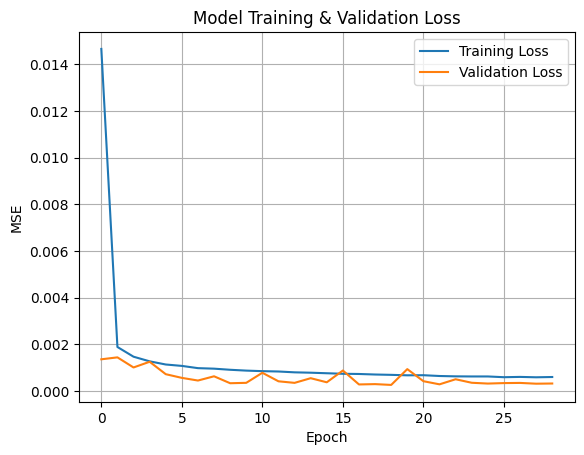

In [147]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Model Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [148]:
preds = model.predict(X_test)
preds = preds.reshape(-1, output_steps, len(target_cols))


108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [149]:
temp_preds = scaler.inverse_transform(preds.reshape(-1, len(target_cols)))[:, 0]
hum_preds = scaler.inverse_transform(preds.reshape(-1, len(target_cols)))[:, 1]


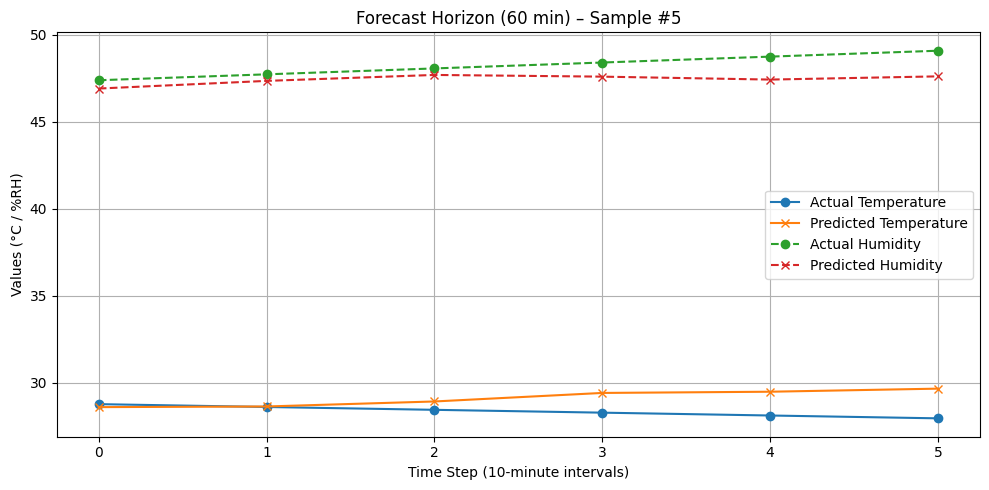

In [156]:

# Choose a sample index to visualize (within test set range)
sample_id = 5  # change this number to view a different forecast

# Predicted and actual sequences (shape: [samples, horizon, variables])
sample_pred = preds[sample_id]
sample_true = y_test[sample_id]

# Inverse transform to original scale
# First flatten & reapply scaler
pred_scaled = sample_pred.reshape(-1, len(target_cols))
true_scaled = sample_true.reshape(-1, len(target_cols))

# Create dummy array for inverse_transform (if scaler expects full features)
pad_pred = np.zeros((output_steps, len(feature_cols)))
pad_pred[:, :2] = pred_scaled
pred_real = scaler.inverse_transform(pad_pred)[:, :2]

pad_true = np.zeros((output_steps, len(feature_cols)))
pad_true[:, :2] = true_scaled
true_real = scaler.inverse_transform(pad_true)[:, :2]

# Plotting
plt.figure(figsize=(10,5))
plt.plot(true_real[:, 0], label='Actual Temperature', marker='o')
plt.plot(pred_real[:, 0], label='Predicted Temperature', marker='x')
plt.plot(true_real[:, 1], label='Actual Humidity', marker='o', linestyle='--')
plt.plot(pred_real[:, 1], label='Predicted Humidity', marker='x', linestyle='--')

plt.title(f'Forecast Horizon ({output_steps*10} min) – Sample #{sample_id}')
plt.xlabel('Time Step (10-minute intervals)')
plt.ylabel('Values (°C / %RH)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [157]:

def inverse_transform_sequence(sequence, scaler, feature_cols, target_cols):
    pad = np.zeros((sequence.shape[0], len(feature_cols)))
    for i, col in enumerate(target_cols):
        pad[:, feature_cols.index(col)] = sequence[:, i]
    return scaler.inverse_transform(pad)[:, :len(target_cols)]


In [158]:
# Flatten y_test and preds
y_true_flat = y_test.reshape(-1, len(target_cols))
preds_flat = preds.reshape(-1, len(target_cols))

# Inverse transform
y_true_inv = inverse_transform_sequence(y_true_flat, scaler, feature_cols, target_cols)
preds_inv = inverse_transform_sequence(preds_flat, scaler, feature_cols, target_cols)


In [160]:

# Split the columns
true_temp = y_true_inv[:, 0]
pred_temp = preds_inv[:, 0]
true_hum = y_true_inv[:, 1]
pred_hum = preds_inv[:, 1]

# Temperature
mae_temp = mean_absolute_error(true_temp, pred_temp)
rmse_temp = np.sqrt(mean_squared_error(true_temp, pred_temp))
r2_temp = r2_score(true_temp, pred_temp)

# Humidity
mae_hum = mean_absolute_error(true_hum, pred_hum)
rmse_hum = np.sqrt(mean_squared_error(true_hum, pred_hum))
r2_hum = r2_score(true_hum, pred_hum)

# Print neatly
print(f"\n🌡️ Temperature Forecast:")
print(f"MAE : {mae_temp:.2f} °C")
print(f"RMSE: {rmse_temp:.2f} °C")
print(f"R²  : {r2_temp:.3f}")

print(f"\n💧 Humidity Forecast:")
print(f"MAE : {mae_hum:.2f} %RH")
print(f"RMSE: {rmse_hum:.2f} %RH")
print(f"R²  : {r2_hum:.3f}")



🌡️ Temperature Forecast:
MAE : 0.59 °C
RMSE: 0.88 °C
R²  : 0.990

💧 Humidity Forecast:
MAE : 0.64 %RH
RMSE: 0.88 %RH
R²  : 0.991


## Fuzzy system

In [168]:
def predict_and_decide(
    model,
    scaler,
    input_sequence,
    input_steps,
    feature_cols,
    target_cols,
    fuzzy_controller
):
    """
    Predicts temperature & humidity from recent input sequence using LSTM,
    then applies fuzzy control to decide fan speed.
    
    Parameters:
    - model: trained Keras model
    - scaler: fitted MinMaxScaler
    - input_sequence: shape (input_steps, len(feature_cols)), latest input
    - input_steps: number of timesteps used by model
    - feature_cols: all feature names (in scaling order)
    - target_cols: e.g. ['greenhouse_temperature_celsius', 'greenhouse_humidity_percentage']
    - fuzzy_controller: skfuzzy.ControlSystemSimulation object

    Returns:
    - temp_pred, hum_pred, fan_speed
    """

    # Step 1: Predict using LSTM
    input_seq = input_sequence.reshape(1, input_steps, len(feature_cols))
    pred = model.predict(input_seq)
    pred = pred.reshape(-1, len(target_cols))

    # Step 2: Inverse scale
    pad = np.zeros((1, len(feature_cols)))
    for i, col in enumerate(target_cols):
        pad[0, feature_cols.index(col)] = pred[0, i]
    pred_inv = scaler.inverse_transform(pad)[0]
    temp_pred, hum_pred = pred_inv[feature_cols.index(target_cols[0])], pred_inv[feature_cols.index(target_cols[1])]

    # Step 3: Pass into fuzzy controller
    fuzzy_controller.input['temperature'] = temp_pred
    fuzzy_controller.input['humidity'] = hum_pred
    fuzzy_controller.compute()
    fan_speed = fuzzy_controller.output['fan_speed']

    print(f"\n🤖 AI Prediction:")
    print(f"🌡️ Temperature: {temp_pred:.2f} °C")
    print(f"💧 Humidity:    {hum_pred:.2f} %RH")
    print(f"🌬️ Fan Speed Decision (fuzzy): {fan_speed:.2f}%")

    return temp_pred, hum_pred, fan_speed


In [173]:

# Antecedents (inputs)
temperature_ctrl = ctrl.Antecedent(np.arange(0, 50, 1), 'temperature')
humidity_ctrl = ctrl.Antecedent(np.arange(0, 100, 1), 'humidity')

# Consequent (output)
fan_ctrl = ctrl.Consequent(np.arange(0, 100, 1), 'fan_speed')

# Membership functions for temperature
temperature_ctrl['low'] = fuzz.trimf(temperature_ctrl.universe, [0, 10, 20])
temperature_ctrl['comfortable'] = fuzz.trimf(temperature_ctrl.universe, [18, 24, 30])
temperature_ctrl['high'] = fuzz.trimf(temperature_ctrl.universe, [28, 35, 45])

# Membership functions for humidity
humidity_ctrl['dry'] = fuzz.trimf(humidity_ctrl.universe, [0, 20, 40])
humidity_ctrl['optimal'] = fuzz.trimf(humidity_ctrl.universe, [35, 50, 65])
humidity_ctrl['humid'] = fuzz.trimf(humidity_ctrl.universe, [60, 75, 100])

# Membership functions for fan speed
fan_ctrl['low'] = fuzz.trimf(fan_ctrl.universe, [0, 25, 50])
fan_ctrl['medium'] = fuzz.trimf(fan_ctrl.universe, [40, 60, 80])
fan_ctrl['high'] = fuzz.trimf(fan_ctrl.universe, [70, 85, 100])


# Recent sequence (already scaled)
recent = test_df[feature_cols].iloc[-input_steps:].values


rule1 = ctrl.Rule(temperature_ctrl['high'] | humidity_ctrl['humid'], fan_ctrl['high'])
rule2 = ctrl.Rule(temperature_ctrl['comfortable'] & humidity_ctrl['optimal'], fan_ctrl['medium'])
rule3 = ctrl.Rule(temperature_ctrl['low'] | humidity_ctrl['dry'], fan_ctrl['low'])

control_sys = ctrl.ControlSystem([rule1, rule2, rule3])
fuzzy_sim = ctrl.ControlSystemSimulation(control_sys)  # 👈 THIS is what you need


# Run full prediction + decision
temp, hum, fan = predict_and_decide(
    model=model,
    scaler=scaler,
    input_sequence=recent,
    input_steps=input_steps,
    feature_cols=feature_cols,
    target_cols=['greenhous_temperature_celsius', 'greenhouse_humidity_percentage'],
    fuzzy_controller=fuzzy_sim
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

🤖 AI Prediction:
🌡️ Temperature: 40.54 °C
💧 Humidity:    41.82 %RH
🌬️ Fan Speed Decision (fuzzy): 84.95%
